In [1]:
import os
import itertools
import tempfile
import warnings
import pandas as pd
import qiime2 as q2
import numpy as np
from scipy.stats import ttest_ind, pearsonr, spearmanr
from biom import load_table, Table
from qiime2.plugins.feature_table.actions import filter_features

#warnings.filterwarnings('ignore')

from skbio import TreeNode
from skbio import OrdinationResults
from skbio.stats.distance import permanova
from skbio.stats.distance import DistanceMatrix
from qiime2.plugins.gemelli.actions import ctf
from qiime2.plugins.emperor.actions import biplot
from qiime2.plugins.qurro.actions import (loading_plot,
                                          differential_plot,
                                          qarcoal)
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.deicode.actions import (rpca,
                                            auto_rpca)
from assets.step_wise_anova import run_stepwise_anova
from qiime2.plugins.diversity.actions import beta_group_significance
#from qiime2.plugins.songbird.actions import multinomial, summarize_paired

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
%matplotlib inline

In [2]:
def pairwise_ttest(df, group_column, value,
                   combinations=[],
                   correction=True):

    # get combos
    if len(combinations) == 0:
        order = sorted(set(df[group_column]))
        combinations = itertools.combinations(order, 2)
        combinations = list(combinations)
    pairwisedf = []
    max_order = {}
    for c1, c2 in combinations:
        # t-test
        t1 = df[df[group_column].isin([c1])][value].values
        t2 = df[df[group_column].isin([c2])][value].values
        t_res = ttest_ind(t1, t2)   
        # tdf
        t_res = pd.DataFrame(t_res,
                             ['test-stat','P'],
                             [c1 + ' vs. ' + c2])
        pairwisedf.append(t_res)
        max_= max(max(t1),max(t2))
        max_order[c1 + ' vs. ' + c2] = max_
    # merge
    pairwisedf = pd.concat(pairwisedf, axis=1).T
    # bonfer correct
    if correction:
        pairwisedf['P'] = pairwisedf['P'] * len(combinations)
    else:
        pairwisedf['P'] = pairwisedf['P']
    return pairwisedf, max_order


def temporal_plot(x_axis, y_axis, df, ax, title, x_label, y_label,
                  title_fontsize, x_fontsize, y_fontsize, hue=None,
                  style=None, size=None, min_x = 0, max_x = 35, err_style='band', 
                  ci=95, cmap='tab10', style_order=None, dashes_=True):

    """

    This wrapper creates beautiful timeseries plots using
    seaborn and matplotlib. 

    Parameters
    ----------
    x_axis : str, required
        X-axis catagory in dataframe -- data
        
    y_axis : str, required
        y-axis catagory in dataframe -- data
        
    df : dataframe, required
        dataframe of data to plot
    
    ax : matplotlib figure object, required
        panel object from matplotlib figure 
    
    title : str, required
        panel title
    
    x_label : str, required
        x label panel title
    
    y_label : str, required
        y label panel title
        
    title_fontsize : int, required
    x_fontsize : int, required
    y_fontsize : int, required
        font sizes 
    
    hue : str, optional
        color by catagory in dataframe -- data
        
    style : str, optional
        style by catagory in dataframe -- data
    
    Returns
    ----------
    matplotlib figure object

    """
    

    # Lineplot across time 
    sns.lineplot(x=x_axis,
                 y=y_axis,
                 hue=hue,
                 style=style,
                 dashes=dashes_,
                 ci=ci,
                 sort=True,
                 markers=style_order,
                 estimator=np.mean,
                 err_style=err_style,
                 palette=cmap,
                 data=df,
                 ax=ax)
    
    
    
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(x_label, color='#000000',
                  fontsize=x_fontsize)
    ax.set_ylabel(y_label, color='#000000',
                  fontsize=y_fontsize, labelpad=0)
    
    # remove all grids, backrounds etc ...
    ax.legend_.remove()        
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_bounds(min_x, max_x)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    return ax


In [3]:
# import data
table = q2.Artifact.load('../data/16S/data-subsets/pma-treatment-table.qza')
metadata = q2.Metadata.load('../data/16S/data-subsets/pma-treatment-metadata.qza')
taxonomy = q2.Metadata.load('../data/16S/all-taxonomy.qza')
tree = q2.Artifact.load('../data/16S/insertion-tree.qza')


mf = metadata.to_dataframe()
x_org = 150
y_org = 600
radius = np.sqrt((x_org - mf['jpl_x'])**2\
                 + (y_org - mf['jpl_y'])**2)
mf['radius'] = radius.values
metadata = q2.Metadata(mf)


In [4]:
filt_table = filter_features(table, min_frequency=10).filtered_table
uwnuni = beta_phylogenetic(filt_table, tree,
                           'unweighted_unifrac')
wuni = beta_phylogenetic(filt_table, tree,
                         'weighted_unifrac')
rpca_res = rpca(filt_table)


In [5]:
mf = metadata.to_dataframe()
{k:set(df.time_numerical) for k, df in mf.groupby('jpl_location_area')}


{'L1': {'1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9'},
 'L10': {'1', '10', '11', '2', '3', '4', '5', '6', '7', '8'},
 'L11': {'10', '11', '3', '4', '6', '7', '9'},
 'L12': {'1', '10', '11', '2', '3', '4', '5', '6', '7', '8'},
 'L13': {'1', '10', '2', '3', '4', '7'},
 'L2': {'1', '11', '2', '3', '6', '8'},
 'L3': {'1', '10', '11', '2', '3', '4', '7', '9'},
 'L4': {'1', '11', '4', '7'},
 'L5': {'11', '2', '3', '4', '6', '7', '8'},
 'L6': {'1', '10', '11', '2', '3', '7'},
 'L7': {'1', '10', '4', '6', '8', '9'},
 'L8': {'10', '2', '3', '5', '6', '8'},
 'L9': {'1', '11', '2', '4', '6', '7', '8', '9'},
 'field control': {'2', '3', '4', '5', '6', '7', '9'},
 'negative control': {'1', '3', '4', '6', '7', '9'}}

In [6]:
bt = table.view(Table).copy()
_, n_samples = bt.shape
min_feature_frequency = 3
rank_ = 4
iter_ = 25
# filter features by N samples presence
def frequency_filter(val, id_, md):
    return (np.sum(val > 0) / n_samples) \
            > (min_feature_frequency / 100)
# filter and import table for each filter above
bt = bt.filter(frequency_filter, axis='observation')
# make QIIME2 type
table_filt = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
ctf_res = ctf(table_filt, metadata,
              'jpl_location_area',
              'time_numerical',
                n_components=rank_,
                max_iterations_als=iter_,
                max_iterations_rptm=iter_,
                n_initializations=iter_,
               feature_metadata=taxonomy)
# save it
for id_, art_ in ctf_res.__dict__.items():
    if id_ != '_fields':
        art_.save(os.path.join('../results/intermediates',
                               'ctf_res-pma-%s' % (id_.replace('_', '-')) ))

In [7]:
# make metadata catagories
mf = metadata.to_dataframe()
mf['Sample-Type'] = mf['jpl_controltype_0_1'].replace({'0':'Rooms','1':'Controls'})
mf['PMA-Treatment'] = mf['jpl_pma'].replace({'FALSE':'No-PMA','TRUE':'PMA'})
mf['pairwise-test'] = mf['Sample-Type'] + ':' + mf['PMA-Treatment']
perm_meta = q2.Metadata(mf)
pairwise_time =[]
for id_, dist_ in {'weighted UniFrac':wuni,
                   'unweighted UniFrac':uwnuni,
                   'Aitchison':rpca_res,
                   'CTF-Aitchison':ctf_res}.items():
    dist_ = dist_.distance_matrix.view(DistanceMatrix)
    perm_meta_ = perm_meta.to_dataframe()
    shared_ = set(dist_.ids) & set(perm_meta_.index)
    res_ = pd.DataFrame(permanova(dist_.filter(shared_),
                                  perm_meta_.loc[shared_,'jpl_location_area'])).T
    res_ = res_[['sample size','number of groups','test statistic','p-value']]
    res_.index = [id_]
    pairwise_time.append(res_)
pairwise_time_df = pd.concat(pairwise_time)
pairwise_time_df.to_csv('../results/tables/SAF-location-permanova.tsv', sep='\t')
pairwise_time_df

,sample size,number of groups,test statistic,p-value
weighted UniFrac,110,15,0.874916,0.74
unweighted UniFrac,110,15,0.981657,0.556
Aitchison,110,15,0.937808,0.592
CTF-Aitchison,108,15,27.3758,0.001


In [8]:
dist = ctf_res.distance_matrix.view(DistanceMatrix)
permanova(dist,
          metadata.to_dataframe().loc[dist.ids,'jpl_location_area'],
          permutations=2000)



method name                PERMANOVA
test statistic name         pseudo-F
sample size                      108
number of groups                  15
test statistic               27.3758
p-value                   0.00049975
number of permutations          2000
Name: PERMANOVA results, dtype: object

In [9]:
ord_subject = ctf_res.subject_biplot.view(OrdinationResults)
p = ord_subject.proportion_explained
pltdf = ord_subject.samples.copy()
pltdf.columns = ['PC%i'%(i+1) for i in pltdf.columns]
pc_cols = pltdf.columns
subject_metdata = metadata.to_dataframe().groupby('jpl_location_area').agg({'jpl_x':'mean',
                                                                            'jpl_y':'mean',
                                                                            'radius':'mean'}).fillna(0)
pltdf = pd.concat([pltdf, subject_metdata], axis=1)
pltdf_corr = pltdf.drop(['field control','negative control'])
corr_ = {i:pearsonr(pltdf_corr[i], pltdf_corr['radius']) for i in pc_cols}
corr_
    


{'PC1': (0.6227565530118289, 0.02299988368908292),
 'PC2': (0.125420862317641, 0.6830791949322779),
 'PC3': (-0.5225332988208512, 0.06694905201904837),
 'PC4': (-0.3666286425537395, 0.21788228751746963)}

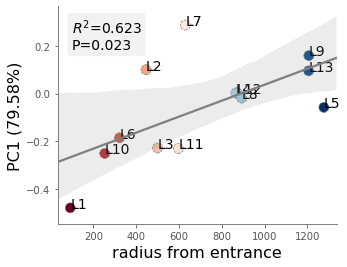

In [10]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

axis_1 = 'radius'
axis_2 = 'PC1'
hue = 'radius'
palette_ = 'RdBu'

# make scatter
kwargs  =   {'edgecolor':"gray",
             'linewidth':0.7,
             'linestyle':'--'}
sns.scatterplot(x=axis_1, y=axis_2,
                hue='radius',
                s=100,
                palette=palette_,
                data=pltdf_corr,
                zorder=-1,
                ax=ax, **kwargs)
# reg line
sns.regplot(x=axis_1, y=axis_2,
           data=pltdf_corr,
           color='gray',
           ax=ax,
           scatter_kws={"s": 0})


r_, p_ = corr_[axis_2]
textstr = '$R^{2}$=%.3f\nP=%.3f' % (r_, p_)
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='gray', alpha=0.1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# add dot annotation
for i in pltdf_corr.index:
    ax.text(pltdf_corr.loc[i, axis_1],
            pltdf_corr.loc[i, axis_2],
            str(i), zorder=-1,
            fontsize=14,
            color='black')

# Hide grid lines
ax.grid(False)
ax.set_facecolor('#f0f0f0')

# get axis labels
ax.set_xlabel('radius from entrance',
         fontsize=16, color='#000000')
ax.set_ylabel('%s (%.2f%%)' %\
          (axis_2, p.loc[list(pc_cols).index(axis_2)] * 100),
         fontsize=16, color='#000000')

# remove all grids, backrounds etc ...
ax.legend_.remove()        
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_bounds(min_x, max_x)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

# save the figure to file
plt.savefig('../results/figures/pc1-radius.pdf',
            dpi=600, 
            bbox_inches='tight',
            edgecolor='none')
plt.show()


In [11]:
ord_subject = ctf_res.subject_biplot.view(OrdinationResults)
ord_subject_invert = OrdinationResults(ord_subject.short_method_name,
                                        ord_subject.long_method_name,
                                        ord_subject.eigvals,
                                        samples=ord_subject.features,
                                        features=ord_subject.samples,
                                        proportion_explained=ord_subject.proportion_explained)
ord_subject_invert = q2.Artifact.import_data('PCoAResults % Properties("biplot")', ord_subject_invert)
subject_metdata = metadata.to_dataframe().groupby('jpl_location_area').agg({'jpl_x':'mean',
                                                                            'jpl_y':'mean',
                                                                            'radius':'mean'}).fillna(0)
subject_metdata.index.name = 'sampleid'
ord_subject_invert_biplot = biplot(ord_subject_invert, taxonomy,
                                   feature_metadata=q2.Metadata(subject_metdata),
                                   number_of_features=ord_subject.samples.shape[0]+1)
ord_subject_invert_biplot.visualization.save('../results/intermediates/inverted_biplot.qzv')


'../results/intermediates/inverted_biplot.qzv'

In [12]:
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex


def painting_biplot(U, p, V, axis_1, axis_2, ax):
    
    annots = []
    seqs = []
    color=cm.RdBu(np.linspace(0,1,U.shape[0]))
    acmap={i:to_hex(c) for i,c in zip(U.index,color)}

    for i in U.index:
        ax.text(U.loc[i, axis_1] * .4,
                U.loc[i, axis_2] * .4,
                str(i), zorder=1)
        annots.append(ax.arrow(0, 0,
                               U.loc[i, axis_1] * .4,
                               U.loc[i, axis_2] * .4,
                               color=acmap[i],
                               alpha=0.8,
                               lw=0.25,
                               ec = 'black',
                               zorder=-1,
                               length_includes_head=True,
                               head_width=.01, width=.004))
        seqs.append(i)

    # Hide grid lines
    ax.grid(False)
    ax.set_facecolor('#f0f0f0')
    
    # plot
    sns.scatterplot(x=axis_1,
                    y=axis_2,
                    data=V,
                    s = 100,
                    #alpha=.5,
                    hue='phylum',
                    palette='Set1',
                    #color='#000000',
                    ax=ax, zorder=-1)


    # get axis labels
    ax.set_xlabel('%s (%.2f%%)' %\
                  (axis_1, p.loc[axis_1,
                                 'proportion_explained'] *100),
                 fontsize=16, color='#000000')
    ax.set_ylabel('%s (%.2f%%)' %\
                  (axis_2, p.loc[axis_2,
                                 'proportion_explained'] * 100),
                 fontsize=16, color='#000000')

    return ax



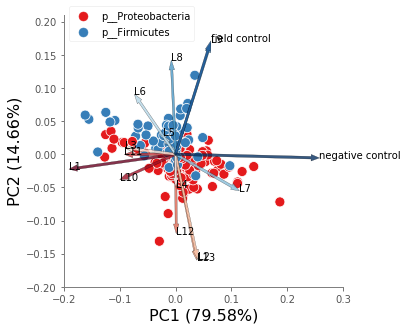

In [13]:
U = ord_subject_invert.view(OrdinationResults).samples
V = ord_subject_invert.view(OrdinationResults).features
cols = ['PC%i' % (pc+1) for pc in range(min(U.shape))]
U.columns = cols
V.columns = cols
p = ord_subject_invert.view(OrdinationResults).proportion_explained
p = pd.DataFrame(p.values, cols, ['proportion_explained'])
U = pd.concat([U, taxonomy.to_dataframe()], axis=1)
#U = U[U['order'].isin(['o__Rhizobiales','o__Bacillales'])]
U = U[U.phylum.isin(['p__Proteobacteria','p__Firmicutes'])]
# plot a biplot
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax = painting_biplot(V, p, U, 'PC1', 'PC2', ax)
ax.set_ylim(-.2,.21)
ax.set_xlim(-.2,.3)

# remove all grids, backrounds etc ...
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_bounds(min_x, max_x)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:], loc=2, 
                         bbox_to_anchor=(0.00, 1.05),
                         prop={'size':10},
                         fancybox=True, framealpha=0.5, 
                         ncol=1, markerscale=1.5,
                         facecolor="white")

# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# save the figure to file
plt.savefig('../results/figures/location-biplot.pdf',
            dpi=600, 
            bbox_inches='tight',
            edgecolor='none')

plt.show()

In [14]:
q2qurro = loading_plot(ctf_res.subject_biplot, table, metadata,
                       feature_metadata=taxonomy)
q2qurro.visualization.save('../results/intermediates/ctf-qurro-loading.qzv')


8240 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.


'../results/intermediates/ctf-qurro-loading.qzv'

In [15]:
# chosen based on exploring with Qurro
lr_all = qarcoal(table,
                 q2.Artifact.import_data('FeatureData[Taxonomy]',
                                         taxonomy.to_dataframe()),
                 'o__Rhizobiales', 'o__Bacillales')
lrdf = lr_all.qarcoal_log_ratios.view(q2.Metadata).to_dataframe()
lrdf = pd.concat([lrdf, metadata.to_dataframe()], axis=1, sort=False)
lrdf = lrdf.dropna(subset=['log_ratio'])
lrdf.head(3)


,Num_Sum,Denom_Sum,log_ratio,collection_timestamp,md_extraction_kit,md_bs_cells,md_control,title,jpl_controltype_0_1,jpl_location_area,...,tm300_8_tool,tm50_8_tool,water_lot,weight,weight_units,well_id,Description,jpl_x,jpl_y,radius
10849.set1.S21.PMA,5.0,61.0,-2.501436,3/30/16,unknown,unknown,unknown,JPL_Project2,0,L2,...,3076189.0,409172Z,RNBD9959,unknown,unknown,C7,set1_set1.S21.PMA_C7,100.0,157.0,445.812741
10849.set2.FC7.PMA,59.0,215.0,-1.293101,6/14/16,unknown,unknown,unknown,JPL_Project2,1,field control,...,3076189.0,409172Z,RNBD9959,unknown,unknown,F11,set2_set2.FC7.PMA_F11,NaN,NaN,NaN
10849.set2.S58.PMA,88.0,110.0,-0.223144,6/1/16,unknown,unknown,unknown,JPL_Project2,0,L9,...,3076189.0,409172Z,RNBD9959,unknown,unknown,D4,set2_set2.S58.PMA_D4,1352.0,494.0,1206.664825


In [16]:
lrdf.groupby('jpl_location_area').mean()['radius'].sort_values()

jpl_location_area
L1                    91.809586
L10                  252.792405
L6                   321.720375
L2                   445.812741
L3                   499.264459
L11                  597.334914
L7                   629.610197
L4                   865.887984
L12                  870.229855
L8                   892.692556
L13                 1205.364675
L9                  1206.664825
L5                  1276.935785
field control               NaN
negative control            NaN
Name: radius, dtype: float64

In [17]:
lrdf_corr = lrdf.dropna(subset=['radius'])
pearsonr(lrdf_corr['log_ratio'],
         lrdf_corr['radius'])

(0.21393170467948078, 0.040591727916448106)

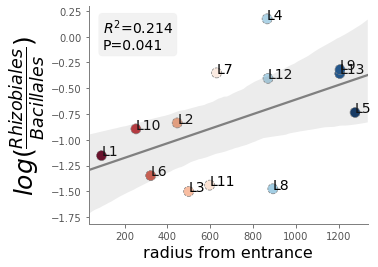

In [20]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

axis_1 = 'radius'
axis_2 = 'log_ratio'
hue = 'radius'
palette_ = 'RdBu'

lrdf_mean = lrdf.groupby('jpl_location_area').agg({'log_ratio':'mean',
                                                   'radius':'first'})

# make scatter
kwargs  =   {'edgecolor':"gray",
             'linewidth':0.7,
             'linestyle':'--'}
sns.scatterplot(x=axis_1, y=axis_2,
                hue='radius',
                s=100,
                palette=palette_,
                data=lrdf_mean,
                zorder=-1,
                ax=ax, **kwargs)
# reg line
sns.regplot(x=axis_1, y=axis_2,
           data=lrdf_mean,
           color='gray',
           ax=ax,
           scatter_kws={"s": 0})


lrdf_corr = lrdf.dropna(subset=['radius'])
r_, p_ = pearsonr(lrdf_corr['log_ratio'],
                  lrdf_corr['radius'])
textstr = '$R^{2}$=%.3f\nP=%.3f' % (r_, p_)
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='gray', alpha=0.1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# add dot annotation
for i in lrdf_mean.index:
    ax.text(lrdf_mean.loc[i, axis_1],
            lrdf_mean.loc[i, axis_2],
            str(i), zorder=-1,
            fontsize=14,
            color='black')

# Hide grid lines
ax.grid(False)
ax.set_facecolor('#f0f0f0')


# get axis labels
ax.set_ylabel('$log(\\frac{%s}{%s})$' % ('Rhizobiales','Bacillales'),
         fontsize=25, color='#000000')
ax.set_xlabel('radius from entrance',
         fontsize=16, color='#000000')
#ax.set_ylabel('%s (%.2f%%)' %\
#          (axis_2, p.loc[list(pc_cols).index(axis_2)] * 100),
#         fontsize=16, color='#000000')

# remove all grids, backrounds etc ...
ax.legend_.remove()        
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_bounds(min_x, max_x)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

# save the figure to file
plt.savefig('../results/figures/lr-radius-corr.pdf',
            dpi=600, 
            bbox_inches='tight',
            edgecolor='none')
plt.show()

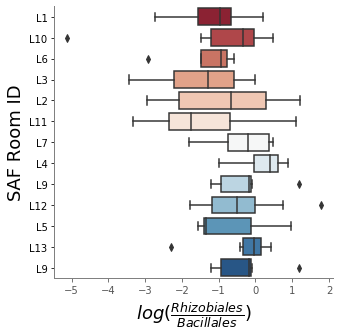

In [21]:
order_ = ['L1','L10','L6','L3','L2','L11','L7','L4','L9','L12',
          'L5','L13','L9']
#,'field control','negative control'
fig, ax = plt.subplots(1,1,figsize=(5,5))
lrdfplt = lrdf[~lrdf.jpl_location_area.isin(['field control','negative control'])]
sns.boxplot(x='log_ratio', y='jpl_location_area',
            data=lrdfplt,palette='RdBu', order=order_, ax=ax)
# get axis labels
ax.set_xlabel('$log(\\frac{%s}{%s})$' % ('Rhizobiales','Bacillales'),
         fontsize=18, color='#000000')
ax.set_ylabel('SAF Room ID',
         fontsize=18, color='#000000')

ax.yaxis.label.set_color('black')
ax.tick_params(axis='y', colors='black')

# remove all grids, backrounds etc ...
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_bounds(min_x, max_x)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

# save the figure to file
plt.savefig('../results/figures/lr-boxplot.pdf',
            dpi=600, 
            bbox_inches='tight',
            edgecolor='none')
        
plt.show()
